# Project 3: Exploratory Data Analysis

---

*****
## Introduction

In this notebook I will be exploring the data scrapped from the two subreddits r/religion and r/cults done in the previous notebook, linked here. My goal in this notebook is to identify common words and distribution of those word as various features across the two subbreddits. In addition I will be carrying out any necessary data cleaning and possible feature engineering that could help build out a claddification model. 

---

## Table of Content 

- [**Reading in Data**](#readin)
- [**Word Count Analysis**](#wordcount)
- [**Pre-processing**](#preprocessing)
- [**Bi-Grams Analaysis**](#bigrams)
- [**Keywords with CountVectorizer**](#keycv)
- [**Keywords with TifDVectorizer**](#Tifd)


### Notebooks
- **[API Data Collection & Data Cleaning Notebook](3-1_DataCollection.ipynb)**
- **[Modeling, Evaluation, and Conclusion](3-3_ModelingEvaluationConclusion.ipynb)**


<a id='readin'></a>

# Reading in saved subbreddit file

---

In [3]:
#Import Packages 
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [6]:
df = pd.read_csv('../Datasets/religion_cults_reddit_preprocessing.csv')

In [7]:
df = df.fillna("")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4400 entries, 0 to 4399
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   subreddit        4400 non-null   object
 1   id               4400 non-null   object
 2   title            4400 non-null   object
 3   selftext         4400 non-null   object
 4   text             4400 non-null   object
 5   subreddit_class  4400 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 206.4+ KB


<a id='wordcount'></a>

# EDA: Word Count Distributions

---

In the below bar graphs below are visualizing average amount of words used in titles and post contents. Based on these visualization **r/cults** has a higher average word count with both these text attributes than **r/religion**. When calculating the % difference the average word count for **r/cults** is **14%** higher than the average word count of **r/religion** within the title text. As continure to explore the text data below we can see how certain topics or words might contribute to longer or shorter titles.

---

In [9]:
#creating a column title_word_count
df['title_word_count'] = df['title'].map(lambda x: len(x.split()))

#crating a column selftext word_count
df['post_word_count'] = df['selftext'].map(lambda x: len(x.split()))

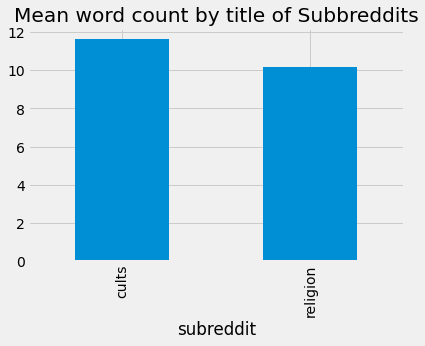

In [10]:
plt.style.use('fivethirtyeight')
df.groupby('subreddit')['title_word_count'].mean().plot.bar()
plt.title('Mean word count by title of Subbreddits');

In [11]:
df.groupby('subreddit')['title_word_count'].mean()

subreddit
cults       11.657727
religion    10.174091
Name: title_word_count, dtype: float64

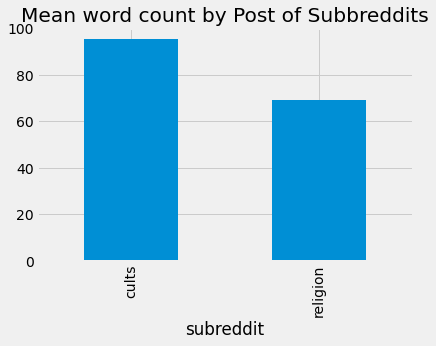

In [12]:
plt.style.use('fivethirtyeight')
df.groupby('subreddit')['post_word_count'].mean().plot.bar()
plt.title('Mean word count by Post of Subbreddits');

In [13]:
df.groupby('subreddit')['post_word_count'].mean()

subreddit
cults       95.551818
religion    69.105455
Name: post_word_count, dtype: float64

<a id='preprocessing'></a>

# EDA: Preprocessing Text

---

As an Initial dive into the text exploration I am goign to look at frequencey of words within the title sections of the two subreddits by vectorizing the title text. To do this I am first going to do some text preprocessing. In the cell below I am creating a function to clean the text of links, punctuation, uppercases, symbols, stopwords, and short words less than 2 letters. After this preprocesssing I will look at common bi-grams and tri-grams by each subreddit title.

In [14]:
#(source: https://stackoverflow.com/questions/54396405/how-can-i-preprocess-nlp-text-lowercase-remove-special-characters-remove-numb)
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

In [15]:
#going to clean the combined title and selftext colum 
df['cleanText']=df['text'].map(lambda s:preprocess(s))

#creating title_clean column of just the title cleaned
df['cleanTitle']=df['title'].map(lambda s:preprocess(s))

<a id='bigrams'></a>

# EDA: Text counting with Bi-grams 

---

In [16]:
# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer(stop_words='english', ngram_range=(2,3))
cv.fit(df['cleanTitle'])

title_cv = cv.transform(df['cleanTitle'])
title_df = pd.DataFrame(title_cv.todense(), columns=cv.get_feature_names())

In [18]:
#concatenating the subreddit columnm with the vectorized title df 
cleanTitle_cv = pd.concat([title_df, df['subreddit']], axis=1)

############## r/cults ###################################################


#filter for subreddit r/cults
cults_cv_title = cleanTitle_cv[cleanTitle_cv['subreddit']== 'cults']

#Dropping subreddit column to sort vectorize text 
cults_cv_title = cults_cv_title.drop(['subreddit'], axis=1)

#selecting top 20
cults_cv_title_20 = cults_cv_title.sum().sort_values(ascending=False).head(20)


############## r/religion ###################################################

#filter for subreddit r/religion
religion_cv_title = cleanTitle_cv[cleanTitle_cv['subreddit']== 'religion']

#Dropping subreddit column to sort vectorize text 
religion_cv_title = religion_cv_title.drop(['subreddit'], axis=1)

#selecting top 20
religion_cv_title_20 = religion_cv_title.sum().sort_values(ascending=False).head(20)

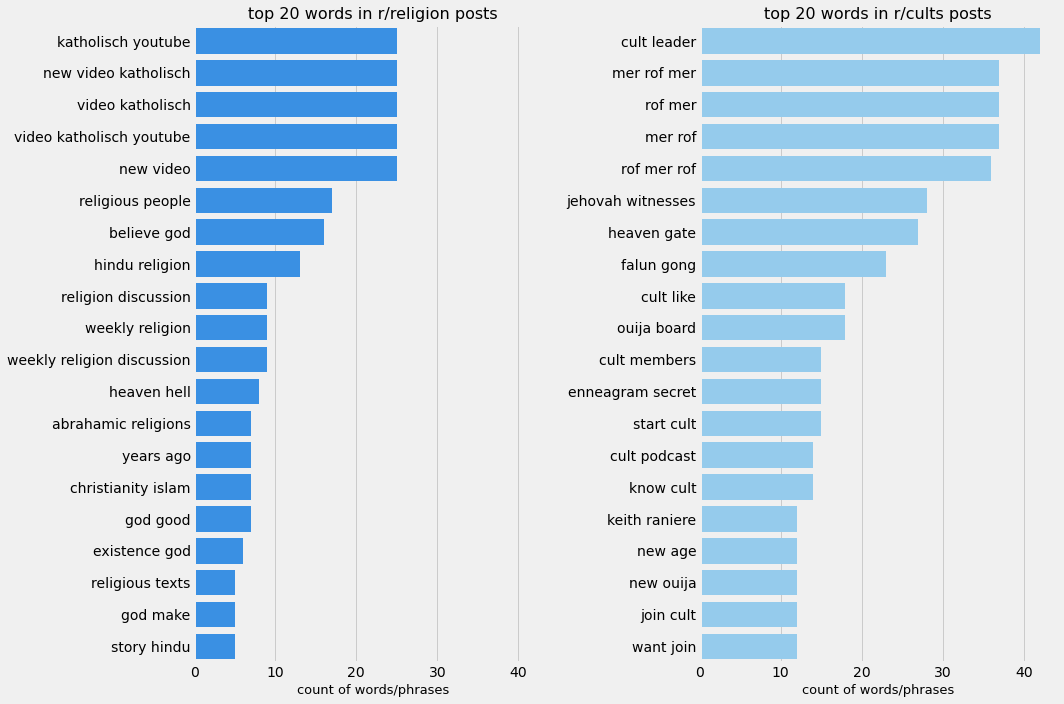

In [20]:
import seaborn as sns
plt.style.use('fivethirtyeight')

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=religion_cv_title_20.index.values, x = religion_cv_title_20,color='dodgerblue',ax=ax[0])
ax[0].set_title('top 20 words in r/religion posts',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=cults_cv_title_20.index.values, x = cults_cv_title_20,color='lightskyblue',ax=ax[1])
ax[1].set_title('top 20 words in r/cults posts',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

#### From the graphs above, a few necessary steps become clear:
1. additional stopwords need to be added to the default sklearn stopwords, such as *religion, religious, cult*. These words are an obvious dead giveaway to the subreddit they belong to and will not be used when modeling so for EDA purposes they do not serve much purpose either.
2. Since my project is based on natural language processing in english, filteing out non-english words or translating them will help decrease noise. 
3. Decreasing noise caused by references to links, videos, other non-text media. 


#### Despite the noise in these two graphs (outlined above) some inital takeaways are:
- In **r/religion** top phrase includes the word ***katholisch***, after a quick google search I've identified this word as a german word for catholic. 
- The term ***heaven*** apears in both the **top 12 most common phrases**.
- The **r/cults** subreddit appears to have words that are more colloquial terms surrounding the notion of a *social group* with words such as *join / joined , member , socicety*. We also can see a more empatic sense of this with terms such as, *leader, secret, prise, and raised*. Additionaly there is this sense of otherness with terms such as *inside, left*.
- In the **r/religion** subreddit there is a very apparant use of various religious faith based words.

Based on these graphs it could be interesting to explore the commnuication styles further. By not extracting the english stopwords we might discover a more prominant trend of **otherness** with words used such as: *us, they, them, theirs, others, inside, outside*. To extend this idea further we might look into pronoun usage within the two subreddits to distinguish if there is a presense of this sociological idea of 'otherness' that is typically comon is destructive cults. 


#### Wait! What is rof mer rof?

Okay, given the nature of the topic cults vs religion I did expet to come across some werid things, but this little side exploration was quite creepy. As we can see above I set out to see the most common 50 phrases across the cleaned title text. As first glance when looking at the .head() four of the enteries has this patter **rof mern**. I went back to the subbreddit **r/cults** to see if there was more detail within the comments or anywherene else on reddit. The specifc post I found is linked [here.](https://www.reddit.com/r/cults/comments/k0ypmn/mer_rof_mer_rof_mer_rof_mer_rof_mer_rof_mer_rof/)
- after translating the comments that were in morse code I found out that this is a name
- another morse code comment said "he is watching you" and "you have been chose"
- And there was a really creepy youtube video.


---

# EDA: Word Analysis

---

Below I've added additional stopwords to the english stopword to account for many of the common words that showed up in the bigrams. My goal to find what type of keywords these two subreddits have that differentiate them and getting rid of excess words will help with reducing the noise and making those singal more clear. 

# EDA on Word Occurance with Additional Stop Words

In [22]:
all_stopwords = stopwords.words('english')
all_stopwords.append('religion')
all_stopwords.append('religions')
all_stopwords.append('cult')
all_stopwords.append('cults')
all_stopwords.append('religious')
all_stopwords.append('video')
all_stopwords.append('podcast')
all_stopwords.append('poll')
all_stopwords.append('view')
all_stopwords.append('also')
all_stopwords.append('even')
all_stopwords.append('amp')
all_stopwords.append('could')
all_stopwords.append('get')
all_stopwords.append('would')
all_stopwords.append('cant')
all_stopwords.append('like')
all_stopwords.append('something')
all_stopwords.append('things')

## R/RELIGION

Below I am the same vectorization of the bi-grams with the new stopwords on my list to see if that helps boost the signal of any words. 

In [35]:
df_religion = df[df['subreddit']== 'religion']

In [37]:
cv_rel = CountVectorizer(stop_words=all_stopwords,min_df=.0025, ngram_range=(2,3))
from itertools import islice
cv_rel.fit(df_religion['cleanText'])
#list(islice(cv.vocabulary_.items(), 20))

CountVectorizer(min_df=0.0025, ngram_range=(2, 3),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [38]:
len(cv_rel.vocabulary_)

255

In [52]:
cv_counts_rel = cv_rel.transform(df_religion['cleanText'])
print('sparse matrix shape:', cv_counts_rel.shape)
print('nonzero count:', cv_counts_rel.nnz)
print('sparsity: %.2f%%' % (100.0 * cv_counts_rel.nnz / (cv_counts_rel.shape[0] * cv_counts_rel.shape[1])))

sparse matrix shape: (2200, 255)
nonzero count: 2365
sparsity: 0.42%


In [53]:
occ_rel = np.asarray(cv_counts_rel.sum(axis=0)).ravel().tolist()
counts_df_rel = pd.DataFrame({'term': cv_rel.get_feature_names(), 'occurrences': occ_rel})
counts_df_rel.sort_values(by='occurrences', ascending=False).head(5)

,term,occurrences
19,believe god,57
95,good evil,50
148,many people,39
253,years ago,37
110,intrusive thoughts,36


## R/CULTS

In [54]:
cv_cult = CountVectorizer(stop_words=all_stopwords, min_df =.0025, ngram_range=(2,3))
from itertools import islice
cv_cult.fit(df_cults['cleanText'])
#list(islice(cv.vocabulary_.items(), 20))

CountVectorizer(min_df=0.0025, ngram_range=(2, 3),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [55]:
len(cv_cult.vocabulary_)

356

In [56]:
df_cults = df[df['subreddit']== 'cults']

In [57]:
cv_counts_cult = cv_cult.transform(df_cults['cleanText'])
print('sparse matrix shape:', cv_counts_cult.shape)
print('nonzero count:', cv_counts_cult.nnz)
print('sparsity: %.2f%%' % (100.0 * cv_counts_cult.nnz / (cv_counts_cult.shape[0] * cv_counts_cult.shape[1])))

sparse matrix shape: (2200, 356)
nonzero count: 3432
sparsity: 0.44%


In [58]:
occ_cults = np.asarray(cv_counts_cult.sum(axis=0)).ravel().tolist()
counts_df_cult = pd.DataFrame({'term': cv_cult.get_feature_names(), 'occurrences': occ_cults})
counts_df_cult.sort_values(by='occurrences', ascending=False).head(5)

,term,occurrences
296,soka gakkai,90
16,anyone know,69
84,falun gong,60
232,ouija board,58
9,anyone else,55


In [60]:
counts_df_cult_20 = counts_df_cult.sort_values(by='occurrences', ascending=False).head(20)
counts_df_rel_20 = counts_df_rel.sort_values(by='occurrences', ascending=False).head(20)

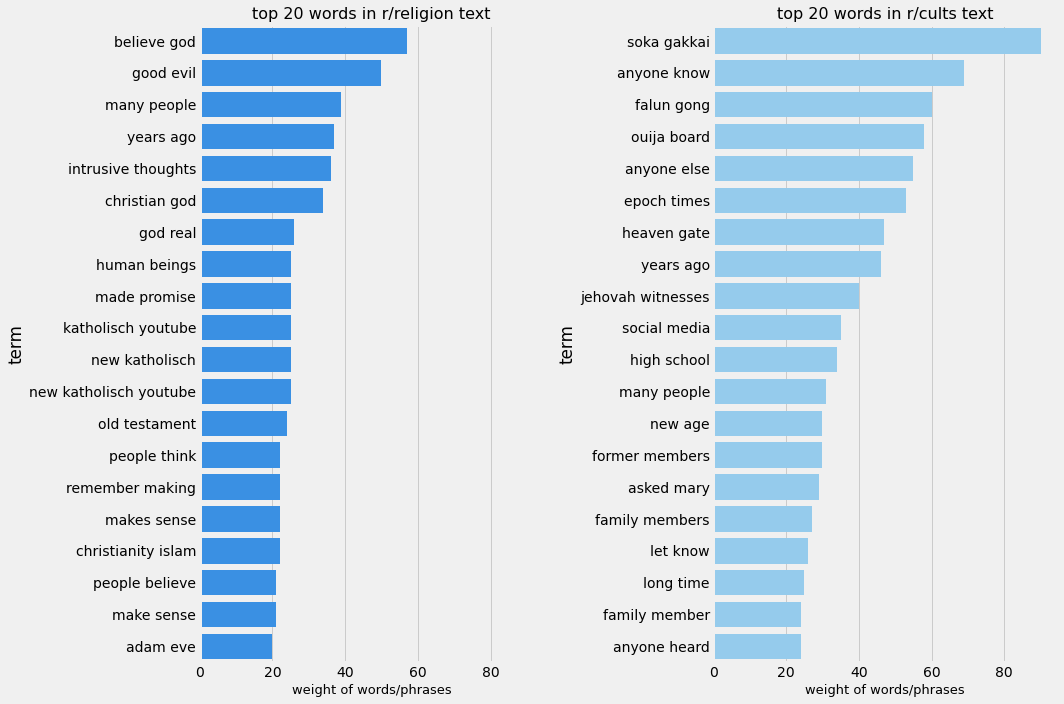

In [61]:
#import seaborn as sns
plt.style.use('fivethirtyeight')

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=counts_df_rel_20['term'], x = counts_df_rel_20['occurrences'],color='dodgerblue',ax=ax[0])
ax[0].set_title('top 20 words in r/religion text',fontsize=16)
ax[0].set_xlabel('weight of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=counts_df_cult_20['term'], x = counts_df_cult_20['occurrences'],color='lightskyblue',ax=ax[1])
ax[1].set_title('top 20 words in r/cults text',fontsize=16)
ax[1].set_xlabel('weight of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

#### The graphs above are plotting the top 50 bi-grams within each subreddit across the text. In these graphs the noise has decreased by the application of the extra stopwords. 

- The first bi-gram that pops out at me is the most occuring bigram of ***soka gakkai*** after a bit of brackground research I learned that this is a is, "a Japanese Buddhist religious movement based on the teachings of the 13th-century Japanese priest Nichiren, [source](https://en.wikipedia.org/wiki/Soka_Gakkai)"

- Similarly the occurance of the bi-gram: **falun gong** apears in **r/cults's** top 3 bi-grams. After further research this group has quite a controversial following surrounded it. While some sources reported this group to be a *new religious movement [source](https://en.wikipedia.org/wiki/Falun_Gong)* other sources report that the group has many destructive cult like practices such as the "demand that the followers think, act and even give their lives at his (Li Hongzhi)  command." I found a very interesteing paper on the sociological study of Falun Gong and their history [here](https://omnilogos.com/falun-gong-in-china-sociological-perspective/).

The presence of controversial groups in the r/cults subreddit led me to further outside research on the groups I learned a lot and found that it only further reeniforces the point that the need for better defintions of religion vs a cult is necessary to avoid missrepresentation, confusion, and success or failure or these groups.

- Ouija board is another topic that has been previously had the followers definined as a [cult](https://en.wikipedia.org/wiki/Ouija#Scientific_investigation).

- In the r/religion subreddit there is (as consistent with the preious bigrams graph) bi-grams that refer to religious aspect such as *god, good ,evil, promise, etc*. This subreddit could be further processed for noise pulling out better keywords. 

- Comparing the two some phrases seem more neutral or positive within in relgion than the cult subreddit which I will explore after Keywords.

---

<a id='bigrams'></a>

# EDA - Identifying Keywords

- Identifying keywords with CountVectorizer

- Identifying Keywords with TifdVectorizer

---

In [421]:
#adding more stopwords below

### CV -  R/RELIGION

In [394]:
all_stopwords.append('really')
all_stopwords.append('make')
all_stopwords.append('say')
all_stopwords.append('think')
all_stopwords.append('may')
all_stopwords.append('made')
all_stopwords.append('said')
all_stopwords.append('see')
all_stopwords.append('way')
all_stopwords.append('still')
all_stopwords.append('one')
all_stopwords.append('anyone')
all_stopwords.append('many')
all_stopwords.append('well')
all_stopwords.append('much')
all_stopwords.append('back')
all_stopwords.append('know')
all_stopwords.append('first')
all_stopwords.append('someone')
all_stopwords.append('want')

In [395]:
cv_rel = CountVectorizer(stop_words=all_stopwords, min_df=0.025)
from itertools import islice
cv_rel.fit(df_religion['cleanText'])
#list(islice(cv.vocabulary_.items(), 20))

CountVectorizer(min_df=0.025,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [396]:
cv_counts_rel = cv_rel.transform(df_religion['cleanText'])
print('sparse matrix shape:', cv_counts_rel.shape)
print('nonzero count:', cv_counts_rel.nnz)
print('sparsity: %.2f%%' % (100.0 * cv_counts.nnz / (cv_counts_rel.shape[0] * cv_counts_rel.shape[1])))

sparse matrix shape: (2200, 122)
nonzero count: 11015
sparsity: 16.24%


In [397]:
occ_rel = np.asarray(cv_counts_rel.sum(axis=0)).ravel().tolist()
counts_df_rel = pd.DataFrame({'term': cv_rel.get_feature_names(), 'occurrences': occ_rel})
counts_df_rel.sort_values(by='occurrences', ascending=False).tail(5)

,term,occurrences
90,questions,71
116,whole,71
100,start,70
3,answer,64
23,curious,63


In [398]:
counts_df_rel_25 = counts_df_rel.sort_values(by='occurrences', ascending=False).head(25)

### CV - R/CULTS

---

In [399]:
cv_cult = CountVectorizer(stop_words=all_stopwords, min_df =.025)
from itertools import islice
cv_cult.fit(df_cults['cleanText'])
#list(islice(cv.vocabulary_.items(), 20))

CountVectorizer(min_df=0.025,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [400]:
cv_counts_cult = cv_cult.transform(df_cults['cleanText'])
print('sparse matrix shape:', cv_counts_cult.shape)
print('nonzero count:', cv_counts_cult.nnz)
print('sparsity: %.2f%%' % (100.0 * cv_counts_cult.nnz / (cv_counts_cult.shape[0] * cv_counts_cult.shape[1])))

sparse matrix shape: (2200, 216)
nonzero count: 19544
sparsity: 4.11%


In [401]:
occ_cults = np.asarray(cv_counts_cult.sum(axis=0)).ravel().tolist()
counts_df_cult = pd.DataFrame({'term': cv_cult.get_feature_names(), 'occurrences': occ_cults})
counts_df_cult.sort_values(by='occurrences', ascending=False).head(5)

,term,occurrences
137,people,918
28,church,475
188,time,421
67,group,381
116,members,370


In [402]:
counts_df_cult_25 = counts_df_cult.sort_values(by='occurrences', ascending=False).head(25)

## Keywords top weighting with CountVectorizer for r/relgion and r/cults subreddits

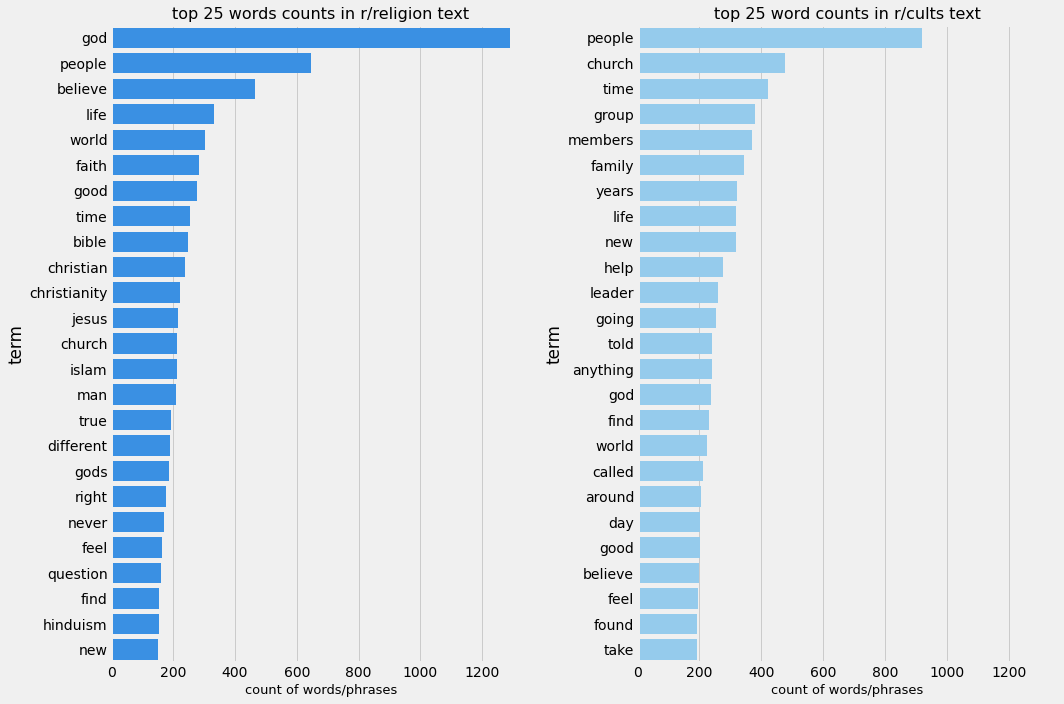

In [403]:
#import seaborn as sns
plt.style.use('fivethirtyeight')

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=counts_df_rel_25['term'], x = counts_df_rel_25['occurrences'],color='dodgerblue',ax=ax[0])
ax[0].set_title('top 25 words counts in r/religion text',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=counts_df_cult_25['term'], x = counts_df_cult_25['occurrences'],color='lightskyblue',ax=ax[1])
ax[1].set_title('top 25 word counts in r/cults text',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

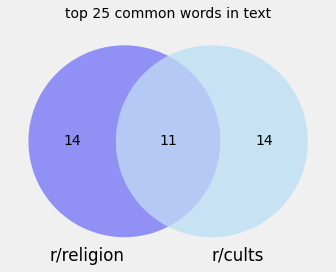

In [404]:
from matplotlib_venn import venn2
plt.style.use('fivethirtyeight')
venn2([set(counts_df_rel_25['term']), set(counts_df_cult_25['term'])], set_labels = ('r/religion','r/cults'), set_colors=('blue', 'lightskyblue'))
plt.title('top 25 common words in text', fontsize=14)
plt.tight_layout()

In [405]:
10/25


0.4

There is about 10 terms that overlap within the top 25 of each of the subreddits. That is about a 40% overlap- this is concerning since it might be harder to differentiate these two subreddits than we thoguht. I am going to investigate the top 25 words by using the TIFD method next to see if that changes the words or commonalities.

----

<a id='Tifd'></a>

## TIFD - R/RELIGION
---

In [422]:
df_religion = df[df['subreddit'] == 'religion']

In [407]:
tvec_religion = TfidfVectorizer(min_df=.0025, max_df=0.85, stop_words=all_stopwords , ngram_range=(1,2))
tvec_weights_rel = tvec_religion.fit_transform(df_religion['cleanText'])

In [408]:
weights_rel = np.asarray(tvec_weights_rel.mean(axis=0)).ravel().tolist()
weights_df_rel = pd.DataFrame({'term': tvec_religion.get_feature_names(), 'weight': weights_rel})
weights_df_rel.sort_values(by='weight', ascending=False).head(20)

,term,weight
788,god,0.044803
1390,people,0.022377
180,believe,0.018162
1013,jesus,0.015428
675,faith,0.014954
195,bible,0.014831
1001,islam,0.014243
306,christianity,0.012700
303,christian,0.012460
818,good,0.012093


## TIFD - R/CULTS

---

In [409]:
df_cults = df[df['subreddit'] == 'cults']

In [410]:
tvec_cults = TfidfVectorizer(min_df=.0025, max_df=0.85, stop_words=all_stopwords , ngram_range=(1,2))
tvec_weights_cults = tvec_cults.fit_transform(df_cults['cleanText'])

In [411]:
weights_cults = np.asarray(tvec_weights_cults.mean(axis=0)).ravel().tolist()
weights_df_cult = pd.DataFrame({'term': tvec_cults.get_feature_names(), 'weight': weights_cults})
weights_df_cult.sort_values(by='weight', ascending=False).head(25)

,term,weight
1932,people,0.020968
1419,join,0.016527
440,church,0.015819
1790,new,0.014086
1495,leader,0.012879
1166,group,0.012265
1665,members,0.012192
956,family,0.011463
1240,help,0.010500
1006,find,0.009674


In [412]:
#sorting for the top 25 terms by weight
weights_df_rel_25 = weights_df_rel.sort_values(by='weight', ascending=False).head(25)

In [413]:
#sorting for the top 25 terms by weight
weights_df_cults_25 = weights_df_cults.sort_values(by='weight', ascending=False).head(25)

## Weighted Keywords by Subreddit using TIFDVectorizer:

---

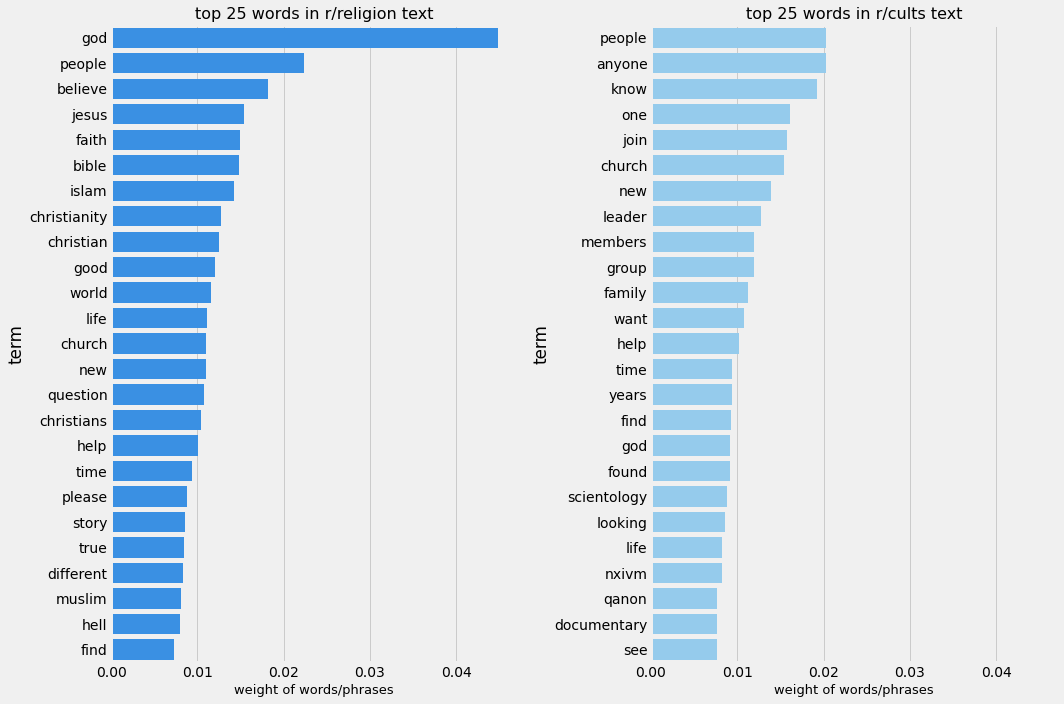

In [414]:
#import seaborn as sns
plt.style.use('fivethirtyeight')

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=weights_df_rel_25['term'], x = weights_df_rel_25['weight'],color='dodgerblue',ax=ax[0])
ax[0].set_title('top 25 words in r/religion text',fontsize=16)
ax[0].set_xlabel('weight of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=weights_df_cults_25['term'], x = weights_df_cults_25['weight'],color='lightskyblue',ax=ax[1])
ax[1].set_title('top 25 words in r/cults text',fontsize=16)
ax[1].set_xlabel('weight of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

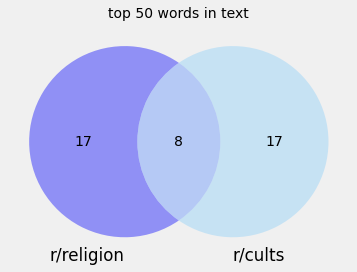

In [415]:
from matplotlib_venn import venn2
plt.style.use('fivethirtyeight')
#plt.figure(linewidth=10, edgecolor="black", facecolor="white")
venn2([set(weights_df_rel_25['term']), set(weights_df_cults_25['term'])], set_labels = ('r/religion','r/cults'), set_colors=('blue', 'lightskyblue'))
plt.title('top 50 words in text', fontsize=14)
plt.tight_layout()

In [416]:
8/25

0.32

This is a little bit better within differentiating the subreddits. There are now 32% of the Top 25 weighted words within the two subbredits in common. It might be best for me to do a TIFD on words if they are not x amount of rows. 

The graphs above are displaying the top 25 words by subbreddit based on weights from the TifD transformer. Looking at these two graphs we can see there is still quite a bit of noise in these text views. The noise I'm reffering to is words that the lemmestizer did not fix like *christianity, christian, find, found*


---

## TIFD VECTOR 

---

In [ ]:
cv_2=CountVectorizer(max_df=0.85,stop_words=all_stopwords ,max_features=1000)
vocab_vector=cv_2.fit_transform(df['cleanText'])
vocab_df = pd.DataFrame(vocab_vector.todense(), columns=cv.get_feature_names())
vocab_df = pd.concat([vocab_df, df['subreddit']], axis=1)

In [468]:
#tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
#tfidf_transformer.fit(df['cleanText'])

In [469]:
df.head()

,subreddit,id,title,selftext,text,subreddit_class,title_word_count,post_word_count,cleanText,cleanTitle,Lemmatize,polarity
0,religion,lwi96e,my boyfriends parents don't want him with me b...,,my boyfriends parents don't want him with me b...,1,13,0,boyfriends parents want christian,boyfriends parents want christian,boyfriend parent want christian,1
1,religion,lwhxen,Demasiado Natural.,,Demasiado Natural.,1,2,0,demasiado natural,demasiado natural,demasiado natural,2
2,religion,lwgtbw,signs of the end times,,signs of the end times,1,5,0,signs end times,signs end times,sign end time,1
3,religion,lwgq4r,What is the text of Isaiah 14:12-17 in the Torah?,I'm having a discussion elsewhere and the post...,What is the text of Isaiah 14:12-17 in the Tor...,1,10,82,text isaiah torah discussion elsewhere poster ...,text isaiah torah,text isaiah torah discussion elsewhere poster ...,1
4,religion,lwgefv,Is Joe Biden allowed to do this?,I am not Catholic but is Joe Biden allowed to ...,Is Joe Biden allowed to do this? I am not Cath...,1,7,30,joe biden allowed catholic joe biden allowed p...,joe biden allowed,joe biden allow catholic joe biden allow play ...,1


<a id=SentAnalysis></a>

# Sentiment Analysis

Below I am goign to explore any possible trends in sentiment. First using the **Vader** model from **SentimentIntesityAnalyzer**. Depending of the quality of this I might further investigate with various sentiment tools. 

---

In [426]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/mackenziedowling/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [472]:
df['polarity']=df['cleanText'].\
    map(lambda x: get_vader_score(x))
polarity=df['polarity'].replace({0:'neg',1:'neu',2:'pos'})

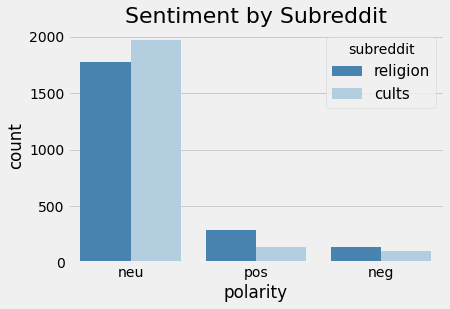

In [473]:
ax = sns.countplot(x=df['polarity'].replace({0:'neg',1:'neu',2:'pos'}), hue="subreddit", data=df, palette='Blues_r')
ax.axes.set_title("Sentiment by Subreddit", fontsize=22)
plt.legend(fontsize=15, title="subreddit");

In the Vader sentiment Analysis the majoirty of the statments were qualified as neutral which is again not ideal for the differentiating these subreddits. 

# Exploratory Analysis Conclusion

The most frequently used words within each othese subreddit share many common words. Although we start too see more distinction in religion with terms related to religious practices and more colloquial terms used in the cults post it will be interesting to see if this is enough of a defining feature in vocabulary to differentiate and predict accuratly the right post when modeling. When analyzing the sentiment of the two subreddit there was very little differece as majoirty were put into neutral. Religion did have about double the amount of positive sentiment post but also more negative post than cults leading me to belive that the lack of consistency in sentiment will not be a good predictor feature for modeling. 

In the next notebook I will be running several models to asses the best model for predicting with accuracy. 
- **[Modeling, Evaluation, and Conclusion](3-3_ModelingEvaluationConclusion.ipynb)**

---
